In [18]:
import cv2
import numpy as np
import math
import imutils
from matplotlib import pyplot as plt
from ponyslayer.utils import imshow, imshows, imdraw, imdraws, imdraws_color, immask, immasks, implot
from ponyslayer import unicorn, transform

In [19]:
image_resolution = 800 # [pixel] Image ratio can be only 1:1 (square)
image_size = 400 # [mm.]
marker_size = 60 # [mm.]
marker_size_error = 0.1 # [ratio] Allowable card size error
min_path_length = 30 # [mm.]
max_path_length = 999 # [mm.]
min_path_width = 5 # [mm.]
max_path_width = marker_size + (marker_size*marker_size_error) # [mm.]
gradient_crop_ratio = 0.9 # Exclude both end (prevent too width range from noise)
min_height = 10
max_height = 20
min_intensity_range = 15 # ช่วงของ intensity ที่แคบที่สุดที่ยังถือว่าเป็น gradient

# Filter Setup

In [20]:
UnsharpMaskBeforeFindMarker = True
BlurKernelSize = (5, 5)

# Load Image

(809, 809, 3)


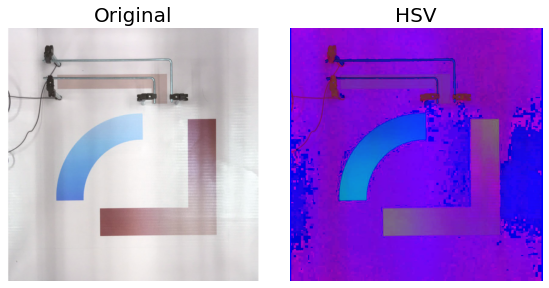

In [21]:
# frame = cv2.imread("Picture3.jpg")
frame = cv2.imread("Real4.jpg")
frame = imutils.resize(frame, height=image_resolution, width = image_resolution)
frame = unicorn.padding_image(frame, 255)
print(frame.shape)
original = frame.copy()
HSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
imshows([original, HSV], ["Original", 'HSV'])
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Filter
White = Low Saturation, Black = Low Value

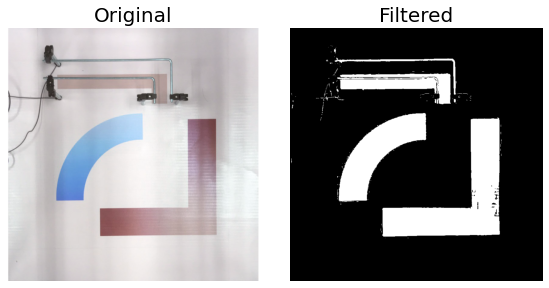

In [22]:
filter_lower = (0, 15, 90)
filter_max = (180, 255, 255)
filter_upper = (180, 255, 255)
filtered = cv2.inRange(HSV, filter_lower, filter_upper)
imshows([original, filtered], ["Original", "Filtered"])

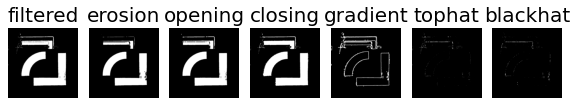

In [29]:
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(filtered,kernel,iterations = 1)
erosion = cv2.erode(filtered,kernel,iterations = 1)
opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(filtered, cv2.MORPH_CLOSE, kernel)
gradient = cv2.morphologyEx(filtered, cv2.MORPH_GRADIENT, kernel)
tophat = cv2.morphologyEx(filtered, cv2.MORPH_TOPHAT, kernel)
blackhat = cv2.morphologyEx(filtered, cv2.MORPH_BLACKHAT, kernel)

imshows([filtered, erosion, opening, closing, gradient, tophat, blackhat], ["filtered", "erosion", "opening", "closing", "gradient", "tophat", "blackhat"])

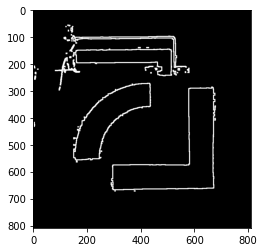

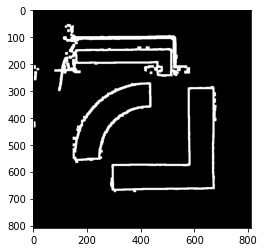

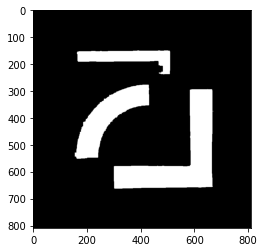

In [39]:
_1closing = cv2.morphologyEx(filtered, cv2.MORPH_CLOSE, kernel)

_2erosion = cv2.erode(_1closing,kernel,iterations = 1)
_3gradient = cv2.morphologyEx(_1closing, cv2.MORPH_GRADIENT, kernel)
imshow(_3gradient)
_4dialation = cv2.dilate(_3gradient,kernel,iterations = 1)
imshow(_4dialation)
_5diff = _1closing - _4dialation
imshow(_5diff)